In [1]:
import pandas as pd

import os
import pickle as pkl
from urllib.request import urlretrieve

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

from IPython.display import Image, display, clear_output

import pandas as pd
import sentencepiece as spm

# Load data

In [2]:

train_formal_file = 'GYAFC_Corpus/Family_Relationships/train/formal'
train_informal_file = 'GYAFC_Corpus/Family_Relationships/train/informal'

In [3]:
with open(train_formal_file) as f:
    formal = [line.rstrip() for line in f]
    
with open(train_informal_file) as f:
    informal = [line.rstrip() for line in f]

In [4]:
train_df = pd.DataFrame({'Formal': formal, 'Informal': informal})
train_df

,Formal,Informal
0,I prefer to let the guy ask me.,"Sure, it's ok, but I always have let the guy a..."
1,I suffer through verbal abuse from my wife.,"Hmmm, I'm a guy suffering from verbal abuse fr..."
2,You will have more friends than you want.,You will have more friends that you want... ;)
3,It's nice that you get to see pictures of who ...,"It's nice, you get to see pictures of who you ..."
4,I need to know what to do.,I NEED TO KNOW WHAT 2 DO
...,...,...
51962,"Of course, it depends on what type of relation...",of corse it depends on what relation u r looki...
51963,"Wear a sign that say ""Hi!""",Wear a sign that says Hi!
51964,I do not like when guys play games with me.,"I don't believe in playing games, I hate when ..."
51965,How old are you?,(or w/e) p.s gurl how old r u ?


In [5]:
for _, row in train_df.sample(n=10).iterrows():
    print(f"Formal: {row.Formal}\nInformal: {row.Informal}\n")

Formal: Before doing anything, my advice is that you consider what it is you would like to do.
Informal: Know your own mind first & then consider what actions you want to take...my best advice...  Good luck!

Formal: Take this other guy for a spin and have some fun.
Informal: Have some fun and take this other guy for a spin.

Formal: She is going out with a truly awesome guy.
Informal: she was going out with a really awesome guy.

Formal: I feel so bad for you. Though the answer to that is simply to wait until they are at least 18 years old.
Informal: I feel so bad for you....the answere to that, though, is you wait till they turn 18...or older.

Formal: That couple would be advised to merely entangle themselves affectionately while experiencing a cinematic selection. Feel less pressured, it proved itself effective personally.
Informal: they should just cuddle infront of an movie or fireplace, relax it works for me

Formal: Try to reach him to see what is going on.
Informal: Try and re

# Pre-process text

In [6]:
root = os.getcwd()
informalPath = os.path.join(root,'GYAFC_Corpus','Family_Relationships','train','informal')
formalPath = os.path.join(root,'GYAFC_Corpus','Family_Relationships','train','formal')
informalTrain = pd.read_csv(informalPath,sep = '\n', header = None)

VOCAB_SIZE = 10000
sp_train_args = f"--input={informalPath} --model_prefix=m --vocab_size={VOCAB_SIZE} --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 --pad_piece=[PAD] --unk_piece=[UNK] --bos_piece=[BOS] --eos_piece=[EOS], --normalization_rule_name=nfkc_cf"

spm.SentencePieceTrainer.train(sp_train_args)
sp = spm.SentencePieceProcessor()
sp.Load('m.model')

True

In [7]:
print('bos=', sp.bos_id())
print('eos=', sp.eos_id())
print('unk=', sp.unk_id())
print('pad=', sp.pad_id())

bos= 2
eos= 3
unk= 1
pad= 0


In [8]:
tokenized_formal = np.array([sp.encode_as_ids(line) for line in formal])
tokenized_informal = np.array([sp.encode_as_ids(line) for line in informal])

In [9]:
print(sp.decode_ids(tokenized_formal[0]))

i prefer to let the guy ask me.


# Figuring out where to cut sentence lenghts

In [10]:
tokenized_lens_formal = np.array([len(element) for element in tokenized_formal])
tokenized_lens_informal = np.array([len(element) for element in tokenized_informal])
print(f"Longest formal sequence: {tokenized_lens_formal.max()}")
print(f"Longest informal sequence: {tokenized_lens_informal.max()}")

Longest formal sequence: 56
Longest informal sequence: 45


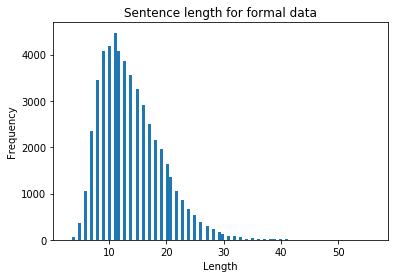

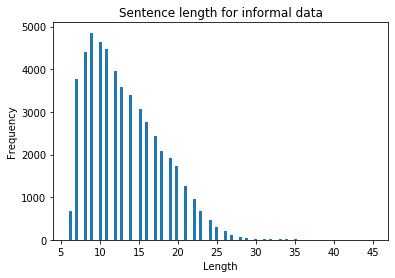

In [11]:
# Plot histogram

import matplotlib.pyplot as plt

pd.Series(tokenized_lens_formal).plot(kind='hist', bins=100)
plt.title('Sentence length for formal data')
plt.xlabel('Length')
plt.show()
pd.Series(tokenized_lens_informal).plot(kind='hist', bins=100)
plt.title('Sentence length for informal data')
plt.xlabel('Length')
plt.show()

# Cutting sentences to set length

In [12]:
sub_tokenized_formal = tokenized_formal[((tokenized_lens_formal <= 30) & (tokenized_lens_informal <= 30))]
sub_tokenized_informal = tokenized_informal[((tokenized_lens_formal <= 30) & (tokenized_lens_informal <= 30))]
sub_formal = np.array(formal)[((tokenized_lens_formal <= 30) & (tokenized_lens_informal <= 30))]
sub_informal = np.array(informal)[((tokenized_lens_formal <= 30) & (tokenized_lens_informal <= 30))]

In [13]:
sub_tokenized_formal.size

51514

In [14]:
sub_tokenized_informal.size

51514

In [15]:
train_df = pd.DataFrame({'Formal': sub_formal, 'Informal': sub_informal})
train_df

,Formal,Informal
0,I prefer to let the guy ask me.,"Sure, it's ok, but I always have let the guy a..."
1,I suffer through verbal abuse from my wife.,"Hmmm, I'm a guy suffering from verbal abuse fr..."
2,You will have more friends than you want.,You will have more friends that you want... ;)
3,It's nice that you get to see pictures of who ...,"It's nice, you get to see pictures of who you ..."
4,I need to know what to do.,I NEED TO KNOW WHAT 2 DO
...,...,...
51509,"Of course, it depends on what type of relation...",of corse it depends on what relation u r looki...
51510,"Wear a sign that say ""Hi!""",Wear a sign that says Hi!
51511,I do not like when guys play games with me.,"I don't believe in playing games, I hate when ..."
51512,How old are you?,(or w/e) p.s gurl how old r u ?


Longest formal sequence: 30
Longest informal sequence: 30


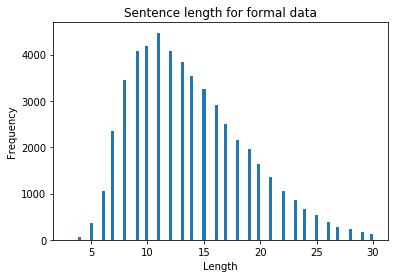

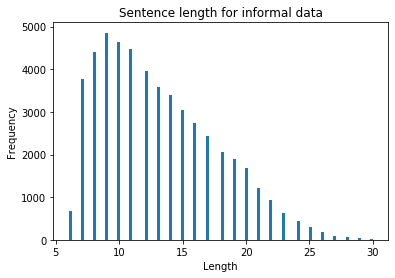

In [16]:
# Plot histogram
sub_tokenized_lens_formal = np.array([len(element) for element in sub_tokenized_formal])
sub_tokenized_lens_informal = np.array([len(element) for element in sub_tokenized_informal])
print(f"Longest formal sequence: {sub_tokenized_lens_formal.max()}")
print(f"Longest informal sequence: {sub_tokenized_lens_informal.max()}")

pd.Series(sub_tokenized_lens_formal).plot(kind='hist', bins=100)
plt.title('Sentence length for formal data')
plt.xlabel('Length')
plt.show()
pd.Series(sub_tokenized_lens_informal).plot(kind='hist', bins=100)
plt.title('Sentence length for informal data')
plt.xlabel('Length')
plt.show()

# Padding sentences to same lenghts

In [17]:
def pad_token_array(array, padded_len):
    len_array = len(array)
    padding = (padded_len - len_array) * [0]
    return torch.LongTensor(array + padding)

In [18]:
sub_tokenized_formal

array([list([7, 669, 8, 132, 13, 61, 72, 42, 4]),
       list([7, 2380, 597, 5670, 1566, 149, 49, 234, 4]),
       list([5, 63, 32, 105, 101, 166, 5, 56, 4]), ...,
       list([7, 34, 24, 23, 76, 73, 394, 777, 25, 42, 4]),
       list([77, 212, 35, 5, 37]),
       list([16, 5, 447, 28, 6, 5, 182, 27, 10, 906, 8, 430, 43, 41, 187, 8, 34, 4])],
      dtype=object)

In [19]:
padded_sub_tokenized_formal = [pad_token_array(element, 30) for element in sub_tokenized_formal]
padded_sub_tokenized_informal = [pad_token_array(element, 30) for element in sub_tokenized_informal]

In [20]:
for x in padded_sub_tokenized_formal:
    assert len(x) == 30
    
for x in padded_sub_tokenized_informal:
    assert len(x) == 30

In [21]:
padded_training_data = padded_sub_tokenized_formal

In [22]:
padded_training_data

[tensor([  7, 669,   8, 132,  13,  61,  72,  42,   4,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0]),
 tensor([   7, 2380,  597, 5670, 1566,  149,   49,  234,    4,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]),
 tensor([  5,  63,  32, 105, 101, 166,   5,  56,   4,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0]),
 tensor([  12,    9,   17,  158,   15,    5,   46,    8,  107, 1455,   29,   88,
            5,   35,  336,    8,    4,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]),
 tensor([  7, 124,   8,  50,  43,   8,  34,   4,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0]),
 tensor([  45,   42,    6,   45,   42,    4, 

# Model

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

In [24]:
class RNN_VAE(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, latent_dim,vocab_size):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) # Couldn't find any way to send backwards through this, does it exist?
        
        self.encoder_lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.decoder_linear = nn.Linear(hidden_dim, vocab_size)
        
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_sigma = nn.Linear(hidden_dim, latent_dim)
        
    
    
    def encode(self, sentence):
        embeds = self.word_embeddings(sentence)
        _, (hidden_state, gate_state) = self.encoder_lstm(embeds.view(SEQ_LEN, -1, self.embedding_dim))
        mu = self.linear_mu(hidden_state) # should the last gate_state be used as well?
        sigma = self.linear_sigma(hidden_state) 
        return mu, sigma
    
    def reparameterize(self, mu, logvar):
        sigma = torch.exp(logvar/2)
        eps = torch.rand_like(sigma)
        return mu + eps*sigma
    
    def decode(self, z, sentence): # Input sentence should maybe be shifted here
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.decoder_lstm(embeds.view(SEQ_LEN, -1, self.embedding_dim), (z, torch.zeros_like(z)))
        output = self.decoder_linear(lstm_out)  # Do i need activation function on this?
        return F.softmax(output, dim=2) # Shouldn't the binary_cross_entropy do the not negative check?
        
    def forward(self, sentence):
        mu, logvar = self.encode(sentence)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z, sentence)
        return output, mu, logvar   # Seems conplex that the output has 100000 classes??

In [25]:
EMBEDDING_DIM = 400
HIDDEN_DIM = 200
LATENT_DIM = 200
BATCH_SIZE = 128
SEQ_LEN = 30

rnn_vae =  RNN_VAE(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                  latent_dim=LATENT_DIM, vocab_size=VOCAB_SIZE )

In [26]:
def ELBO_loss(recon_sentence, sentence, mu, logvar):
    BCE = F.binary_cross_entropy(recon_sentence, sentence, reduction='sum') # Loss function is not right what should it be?
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    return BCE + KLD

In [27]:
optimizer = optim.Adam(rnn_vae.parameters(),lr= 1e-3)

In [28]:
from tqdm import tqdm
from torch.utils.data import DataLoader

In [29]:
N_train = len(padded_training_data)


train_data_loader = DataLoader(padded_training_data, batch_size=BATCH_SIZE) # last batch fucks up set batch size to -1 all places
training_loss, validation_loss = [], []

def train(epoch):
    rnn_vae.train()
    train_loss = 0
    for index, sentence in enumerate(train_data_loader): # todo figure out the shifting thing and create data loader
        sentence = torch.LongTensor(sentence)
        optimizer.zero_grad()
        output, mu, logvar = rnn_vae.forward(sentence)
        one_hot_target = torch.nn.functional.one_hot(sentence, num_classes=VOCAB_SIZE)\
            .view(SEQ_LEN, -1, VOCAB_SIZE).float()
        loss = ELBO_loss(recon_sentence=output, sentence=one_hot_target, mu=mu, logvar=logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        print(f"Batch {index}/{len(train_data_loader)} loss: {loss.item()}")
    train_loss /= N_train
    print(f"Epoch {epoch} train loss {train_loss}")
    return train_loss

'''        
def test(epoch):
    vae.eval()
    test_loss = 0
    for sentence in test_data_loader:
        x = x.view(-1, 784)
        recon_x, mu, logvar = vae.forward(x)
        test_loss += ELBO_loss(recon_x, x, mu, logvar).item()
    test_loss /= N_test
    print(f"Epoch {epoch} test loss {test_loss}")
    return test_loss
'''


def print_reconstruction():
    test_batch = next(iter(train_data_loader))
    test_sentence = sp.decode_ids(test_batch[0].tolist())
    output, _, _ = rnn_vae.forward(test_batch)
    output_ids = output[:,0,:]
    recon_ids = [np.argmax(output).item() for output in output.detach()]
    recon_sentence = sp.decode_ids(recon_ids)
    print(f"Real sentence: {test_sentence}")
    print(f"Reconstructed sentence: {recon_sentence}")
    

In [ ]:
N_epochs = 1
for epoch in range(N_epochs):
    train(epoch)
    if epoch%10 == 0:
        print(f"Epoch {epoch}:")
        print_reconstruction()


Batch 0/403 loss: 35685.26953125
Batch 1/403 loss: 33409.47265625
Batch 2/403 loss: 31428.15625
Batch 3/403 loss: 29923.1015625
Batch 4/403 loss: 28123.515625
Batch 5/403 loss: 26002.22265625
Batch 6/403 loss: 24145.908203125
Batch 7/403 loss: 23483.515625
Batch 8/403 loss: 21860.45703125
Batch 9/403 loss: 19846.927734375
Batch 10/403 loss: 18968.548828125
Batch 11/403 loss: 17450.10546875
Batch 12/403 loss: 15686.6279296875
Batch 13/403 loss: 15608.8349609375
Batch 14/403 loss: 15347.017578125
Batch 15/403 loss: 15012.900390625
Batch 16/403 loss: 15741.630859375
Batch 17/403 loss: 14701.5224609375
Batch 18/403 loss: 14518.3212890625
Batch 19/403 loss: 15037.6708984375
Batch 20/403 loss: 14256.4912109375
Batch 21/403 loss: 15542.640625
Batch 22/403 loss: 15711.6201171875
Batch 23/403 loss: 14393.5849609375
Batch 24/403 loss: 13816.8388671875
Batch 25/403 loss: 13824.4501953125
Batch 26/403 loss: 13218.2265625
Batch 27/403 loss: 13335.26171875
Batch 28/403 loss: 13423.42578125
Batch 29/

Batch 229/403 loss: 2017.85888671875
Batch 230/403 loss: 2204.35498046875
Batch 231/403 loss: 2300.922119140625
Batch 232/403 loss: 1980.4124755859375
Batch 233/403 loss: 2306.966064453125
Batch 234/403 loss: 1923.71142578125
Batch 235/403 loss: 1864.2342529296875
Batch 236/403 loss: 1982.9249267578125
Batch 237/403 loss: 1893.482177734375
Batch 238/403 loss: 2249.994384765625
Batch 239/403 loss: 2117.813720703125
Batch 240/403 loss: 2086.36474609375
Batch 241/403 loss: 2047.418701171875
Batch 242/403 loss: 1996.1676025390625
Batch 243/403 loss: 1700.9146728515625
Batch 244/403 loss: 2217.183349609375
Batch 245/403 loss: 1860.7474365234375
Batch 246/403 loss: 2183.65234375
Batch 247/403 loss: 2128.9541015625
Batch 248/403 loss: 1976.4013671875
Batch 249/403 loss: 1961.361083984375
Batch 250/403 loss: 1652.6656494140625
Batch 251/403 loss: 1966.7138671875
Batch 252/403 loss: 1816.5364990234375
Batch 253/403 loss: 1599.998291015625
Batch 254/403 loss: 1654.9755859375
Batch 255/403 loss: 

In [ ]:
test_batch = next(iter(train_data_loader))

In [ ]:
output, mu, logvar = rnn_vae.forward(test_batch)
print(f"output shape: {output.shape}")
print(f"mu shape: {mu.shape}")
print(f"logvar shape: {logvar.shape}")

In [ ]:
nn.Embedding(vocab_size, embedding_dim)

In [ ]:
print_reconstruction() # Needs to be remade to it can run